In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
import numpy as np

import camb
from camb import model, initialpower
import pandas as pd

In [27]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location(
    "spectra", "../shared/spectra.py")
spectra = importlib.util.module_from_spec(spec)
sys.modules["spectra"] = spectra
spec.loader.exec_module(spectra)

In [3]:
omega_index = 1 # while we debug, we confine our attention to just one value
onh2 = spectra.omegas_nu[omega_index]
onh2_str = spectra.omnu_strings[omega_index]
snap_index=0

In [4]:
model0 = {'OmM': 0.318584094,
 'OmL': 0.681415906,
 'OmK': 0.0,
 'OmC': 0.268584094,
 'OmB': 0.05,
 'h': 0.67,
 'w0': -1,
 'wa': 0,
 'omch2': 0.120567,
 'ombh2': 0.022445,
 'n_s': 0.96,
 'A_s': 2.12723788013000E-09,
}

In [5]:
'''
First, we need to define a Pandas table containing my exotic cosmologies.
'''
num_exotic = 9
def row_conglomerator():
    rows = [spectra.get_cosmology() for i in range(num_exotic)]
    rows.insert(0, model0)
    conglomerate = {}
    for key in rows[0].keys():
        conglomerate[key] = [rows[0][key]]
        for i in range(1, num_exotic + 1):
            conglomerate[key].append(rows[i][key])
    return conglomerate
            
conglomerate = row_conglomerator()
cosm = pd.DataFrame.from_dict(conglomerate)
cosm.loc[9]

OmM      2.757967e-01
OmL      7.329292e-01
OmK     -8.725981e-03
OmC      2.325119e-01
OmB      4.328488e-02
h        7.200981e-01
w0      -9.947410e-01
wa       1.449281e-01
omch2    1.205670e-01
ombh2    2.244500e-02
n_s      9.600000e-01
A_s      2.400747e-09
Name: 9, dtype: float64

In [30]:
m0_only = pd.Series(model0).to_frame().T
m0_only

,OmM,OmL,OmK,OmC,OmB,h,w0,wa,omch2,ombh2,n_s,A_s
0,0.318584,0.681416,0.0,0.268584,0.05,0.67,-1.0,0.0,0.120567,0.022445,0.96,2.127238e-09


In [31]:
# It's a waste of time to consider all of the omegas and snapshots, so we're
# making heavy use of skips.
spec_sim = spectra.better_battery(spectra.omegas_nu, spectra.omnu_strings,
    skips_omega = [0, 2, 3], skips_model=[], skips_snapshot=[1, 2, 3],
    models=m0_only)

0
1
2


In [33]:
# The target should always be selected at snapshot
# 0, i.e. z=2
target = spec_sims[onh2_str][0][0]['s12_massless'][0]

# We'll evaluate each cosmology at the corresponding
# redshift entry here, to keep things even.
redshifts = [2]
for i in range(1, num_exotic + 1):
    z = spectra.match_s12(target, 0.001, cosm.loc[i])
    redshifts.append(z)

z: 1 s12: 0.4655938980520892
z: 50.5 s12: 0.019150662295322595
z: 25.75 s12: 0.03673893345713096
z: 13.375 s12: 0.06834694112111402
z: 7.1875 s12: 0.12018403590195066
z: 4.09375 s12: 0.19328643514854305
z: 2.546875 s12: 0.27619214127233055
z: 1.7734375 s12: 0.3490846059817369
z: 2.16015625 s12: 0.3086743533720862
z: 1.966796875 s12: 0.32773649682393324
z: 2.0634765625 s12: 0.31794063703002384
z: 2.01513671875 s12: 0.3227698809102125
z: 1.990966796875 s12: 0.32523569502565686
z: 2.0030517578125 s12: 0.3239984565275958
z: 1 s12: 0.4655938980520892
z: 50.5 s12: 0.019150662295322595
z: 25.75 s12: 0.03673893345713096
z: 13.375 s12: 0.06834694112111402
z: 7.1875 s12: 0.12018403590195066
z: 4.09375 s12: 0.19328643514854305
z: 2.546875 s12: 0.27619214127233055
z: 1.7734375 s12: 0.3490846059817369
z: 2.16015625 s12: 0.3086743533720862
z: 1.966796875 s12: 0.32773649682393324
z: 2.0634765625 s12: 0.31794063703002384
z: 2.01513671875 s12: 0.3227698809102125
z: 1.990966796875 s12: 0.325235695025656

In [45]:
# This is a disgusting hack, but it's quite efficient
def decoy_parser(mindex):
    return [redshifts[mindex]]

spectra.parse_redshifts = decoy_parser

spec_sims = spectra.better_battery(spectra.omegas_nu, spectra.omnu_strings,
    skips_omega = [0, 2, 3], skips_model=[], skips_snapshot=[],
    models=cosm)

0
1
2


0
0
0
0
0
0
0
0
0
0


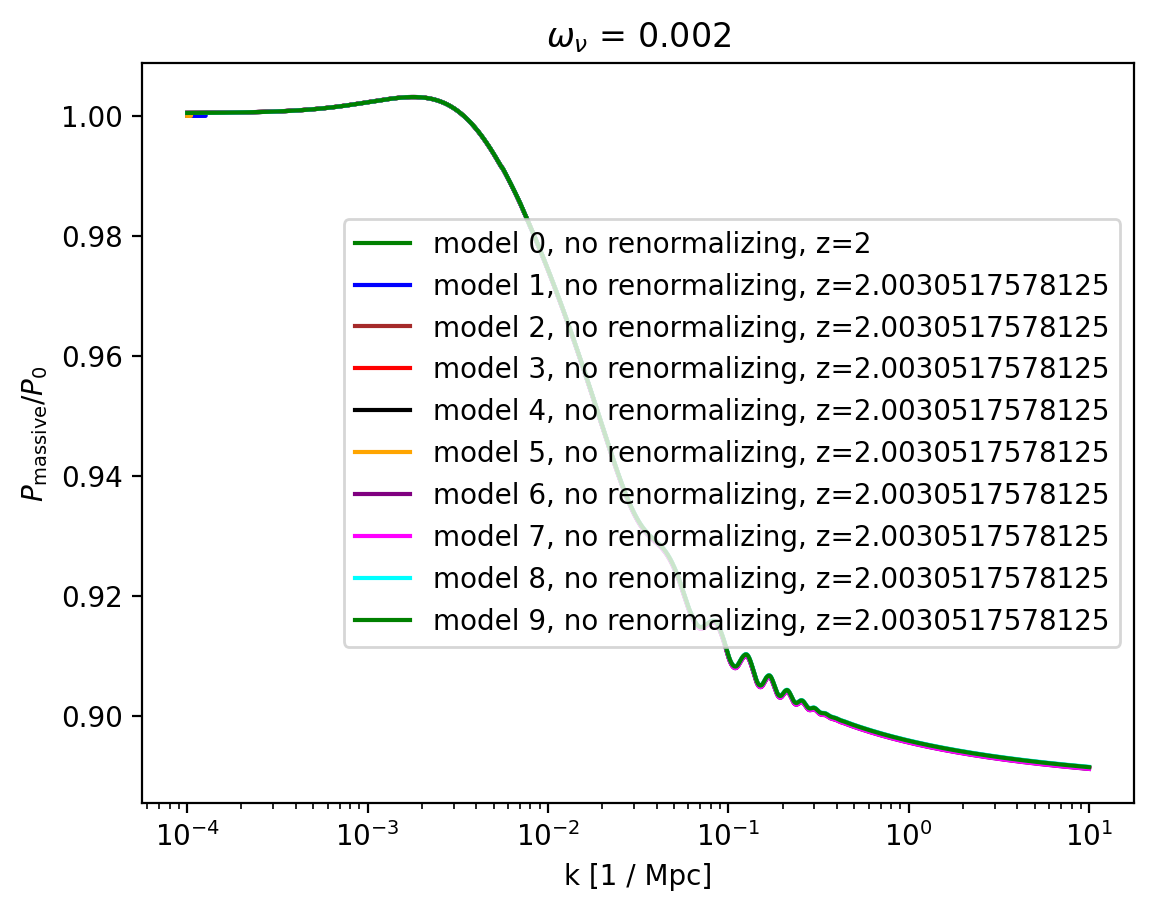

In [46]:
colors = spectra.colors * 2
styles = spectra.styles * 2
for i in range(len(spec_sims[onh2_str])):
    if spec_sims[onh2_str][i] is None:
        continue
    h = cosm.loc[i]["h"]
    for j in range(len(spec_sims[onh2_str][i])):
        if spec_sims[onh2_str][i][j] is None:
            continue
        plt.plot(spec_sims[onh2_str][i][j]["k"],
            spec_sims[onh2_str][i][j]["P_nu"] / \
            spec_sims[onh2_str][i][j]["P_no"],
            label="model " + str(i) + ", no renormalizing, z=" + \
            str(spectra.parse_redshifts(i)[j]), c=colors[i],
            linestyle=styles[i])
    plt.xscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.ylabel(r"$P_\mathrm{massive} / P_0$")
    plt.title(r"$\omega_\nu$ = " + onh2_str)
    plt.legend()

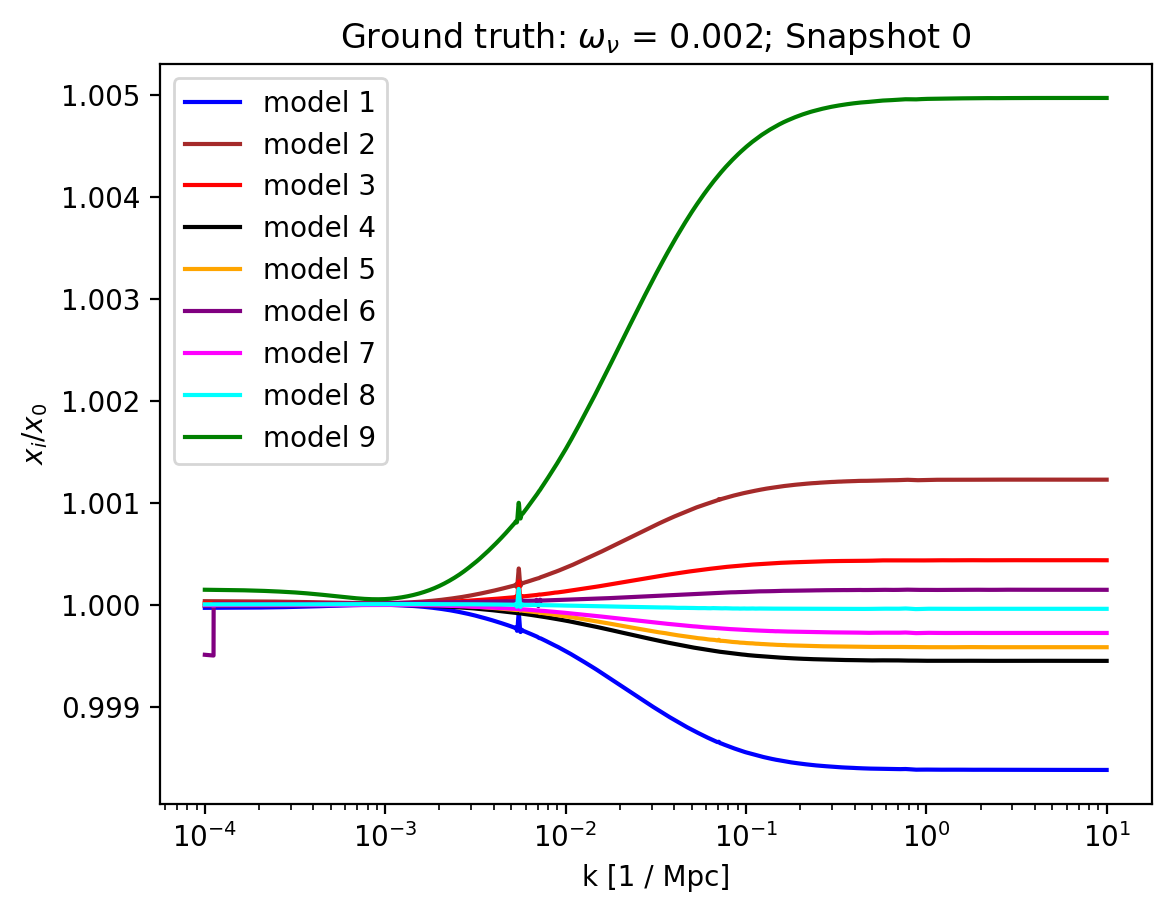

In [8]:
fig, axs = plt.subplots()
ks, rats = spectra.model_ratios_true(snap_index, spec_sims[onh2_str], axs,
    massive='x', skips=[], omnuh2_str=onh2_str, models=cosm);

In [9]:
true_asymptotes = np.array([rats[i][len(rats[i]) - 1] for i in range(len(rats))])

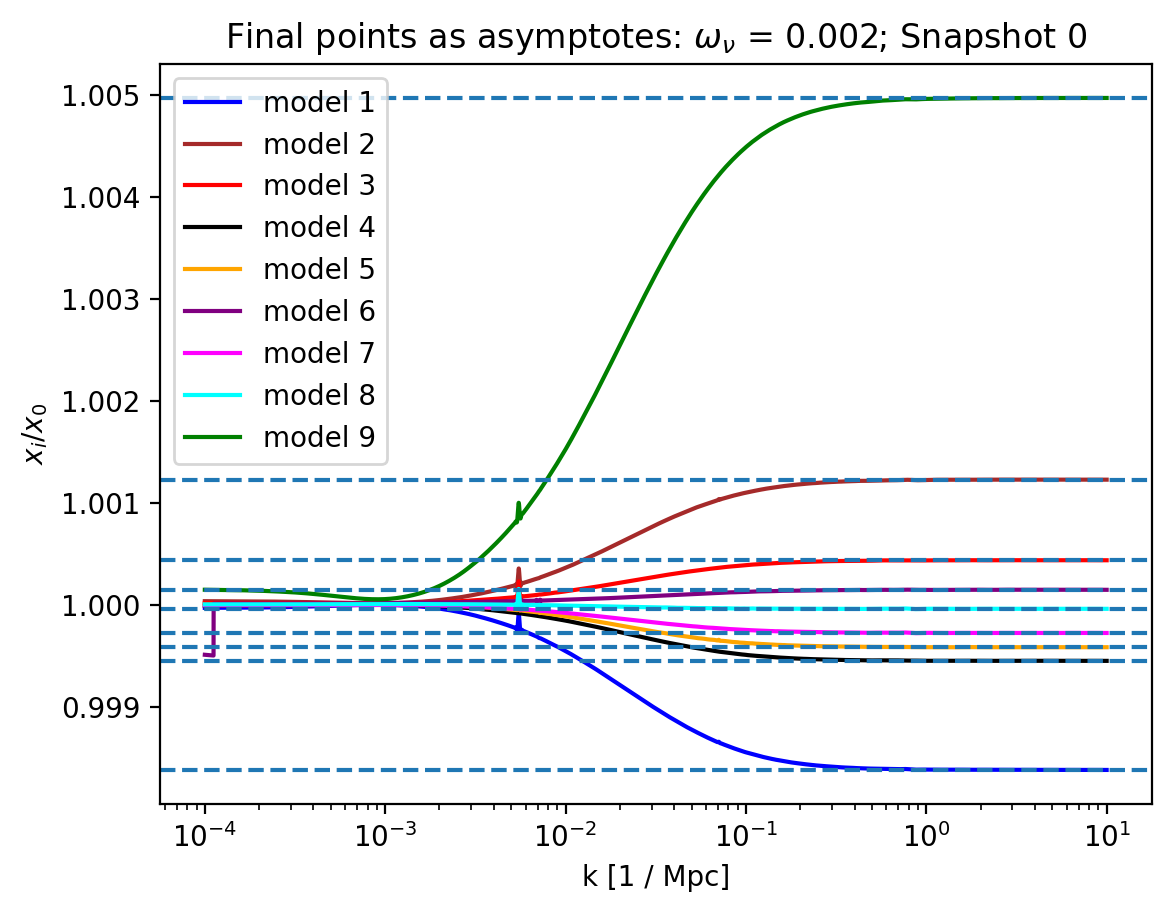

In [10]:
fig, axs = plt.subplots()
spectra.model_ratios_true(snap_index, spec_sims[onh2_str], axs,
    massive='x', skips=[], omnuh2_str=onh2_str,
    title="Final points as asymptotes", models=cosm)
for asymptote in true_asymptotes:
    axs.axhline(asymptote, linestyle='--')

y-intercept for this fit is 1.0004861673716674
slope for this fit is -1.0302539088334985
Reduced chi squared value for this fit: 3.076232015908561e-06


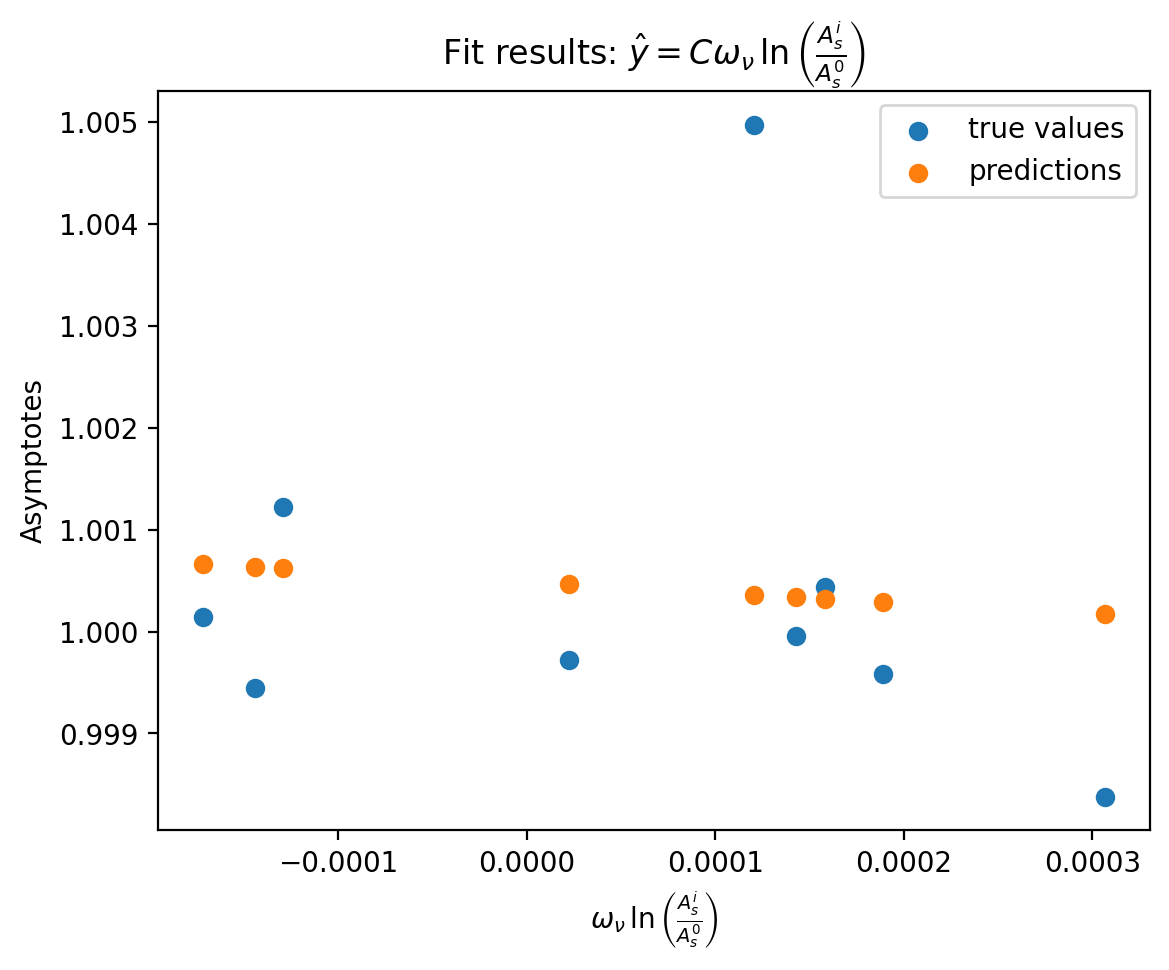

In [11]:
from numpy.polynomial.polynomial import polyfit
A_s = [cosm.loc[i]["A_s"] for i in range(1 + num_exotic)]
x6 = onh2 * np.log(A_s[1:] / A_s[0])

model_desc_6 = r"\omega_\nu \, \ln \left( \frac{A_s^i}{A_s^0} \right)$"

#print(len(true_asymptotes))
#print(len(A_s))

plt.scatter(x6, true_asymptotes, label="true values")

b6, m6 = polyfit(x6, true_asymptotes, 1)

pred6 = m6 * x6 + b6
plt.scatter(x6, pred6, label="predictions")

print("y-intercept for this fit is", b6)
print("slope for this fit is", m6)

plt.ylabel("Asymptotes")
plt.xlabel("$" + model_desc_6)
plt.title(r"Fit results: $\hat{y} = C" + model_desc_6)
plt.legend()

chis6 = (true_asymptotes - pred6) ** 2 / pred6
red_chisq6 = sum(chis6) / len(x6)
print("Reduced chi squared value for this fit:", red_chisq6)

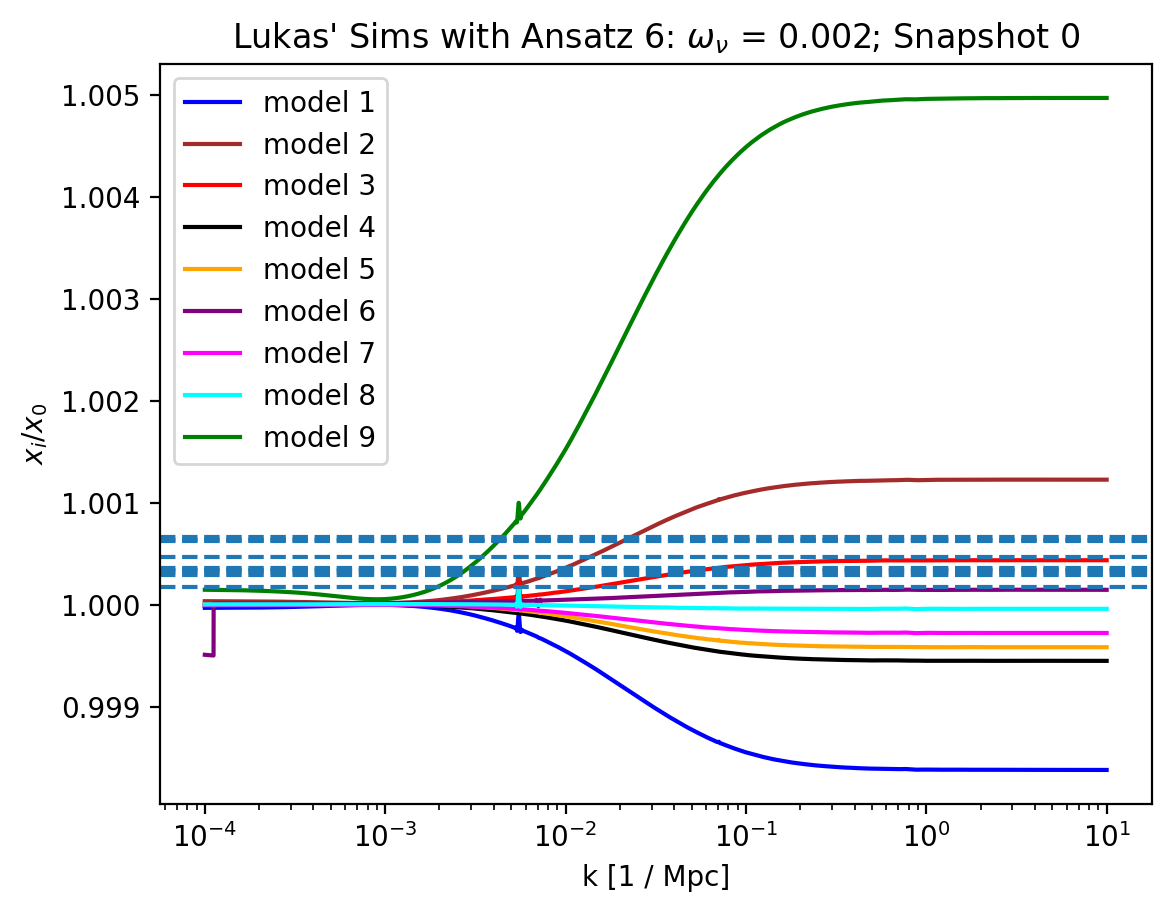

In [12]:
fig, axs = plt.subplots()
spectra.model_ratios_true(snap_index, spec_sims[onh2_str], axs,
    massive='x', omnuh2_str=onh2_str, models=cosm,
    title="Lukas' Sims with Ansatz 6")
#axs.get_legend().remove()
for i in range(len(true_asymptotes)):
    axs.axhline(m6 * x6[i] + b6, linestyle='--')